# TP 2 : Computer Vision

## Part 3 : motion estimation

#### Done by Siwar ABBES

In this part of the TP, we are going to look at the following method for estimating motion :

- block matching

First, let us again load some packages and define some helper functions

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

def display_motion(img_1,img_2,key_pts,motion,file_save=''):
    
    motion_x = motion[:,0]
    motion_y = motion[:,1]
    
    img_size = img_1.shape
    
    head_width=2.0
    head_length=3.0

    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    ax = plt.imshow(img_1,cmap='gray')

    print(key_pts.shape[0])
    for i in range(0,key_pts.shape[0]):
        x = key_pts[i,0]
        y = key_pts[i,1]
        plt.arrow(x,y, motion_x[i],motion_y[i] , color='r',
            head_width=head_width, head_length=head_length,)
    plt.gca().set_axis_off()
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())

    if (file_save != ''):
        plt.savefig(file_save, bbox_inches = 'tight', pad_inches = 0)

file_dir = 'images/'
file_name_1 = 'afgrunden_1'
file_name_2 = 'afgrunden_2'
file_ext = '.png'
img_1,_ = read_image(file_dir+file_name_1+file_ext)
img_2,_ = read_image(file_dir+file_name_2+file_ext)

img_size = img_1.shape
img_size
display_image(img_1)


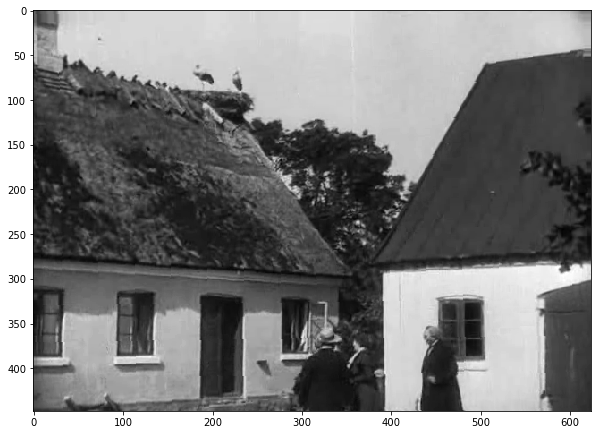

In [2]:
display_image(img_2)

__Question__ What sort of motion do you think is there between img_1 and img_2 ? You may want to flip between one image and another in an external viewer.

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span> <br>
    
We can notice a slight counter-clockwise rotation between the two images.

## Block matching

Block matching is a very intuitive algorithm for motion estimation. We choose a patch size, and for each patch $\Psi_p$ in the first frame, we look for the patch $\Psi_q$ which is the most similar, in a certain region around the original position. The motion $(\delta_x,\delta_y)$ is then defined as $(\delta_x,\delta_y) = q-p$, such that : 

$
\begin{cases}
q_x = p_x+\delta_x\\
q_y = p_y+\delta_y
\end{cases}
$

The ''similarity'' between two patches is the sum of squared differences (SSD) :

$d(\Psi_p,\Psi_q) = \sum_{i \Psi} \left( I(p+i) - I(q+i) \right)^2,$

where $\Psi$ is the patch neighbourhood (a square).

We are going to be implementing block matching in a function called ``block_matching``. However, this can take a lot of time, so we only carry it out on a subset of the pixels, which we will call ``key_pts``. This will be a matrix of size $(N,2)$, where $N$ is the number of keypoints, and where each line has the following format :

- $[x,y]$

Create this function now, with the following parameters :

- block_size = 7 (the patch size)
- search_size = 15 (the maximum distance we search for the same patch in)

You will have to deal with border conditions. There are two ways of doing this :

- not allowing the patch search to go near to the borders (no closer than half the patch size)
- making partial patch comparisons

You can choose either method. The first is slightly easier to implement, but potentially incorrect near the borders. The second is more correct, but you have to make sure to make partial patch comparisons.

Make sure you do __not__ carry out the patch distance calculation with a loop (which would not be very optimal). You can first create the patch neighbourhood $\Psi$ with

- ``np.meshgrid``

and then take the SSD of the two patches.

Fill in the following function.

In [3]:
block_size = 7 # the patch size
search_size = 15 # the maximum distance we search for the same patch in

In [9]:
def block_matching(img_1,img_2,key_pts):
    
    n , m = img_1.shape
    motion  = np.zeros(key_pts.shape)
    
    for idx, key in enumerate(key_pts) : 
        
        py , px = key[0], key[1]
        xmax ,ymax =  min(block_size , n - px ),min(block_size , m - py )
        xmin , ymin = max(-block_size, -px) , max(-block_size, -py)
        ix , iy = np.meshgrid(range(xmin,xmax),range(ymin,ymax)) # create the patch neighbourhood  
        SSD_min = 100
        
        for qx in range(px - search_size , px + search_size):
            for qy in range(py - search_size , py + search_size): 
                
                if (qx + xmin >= 0) & (qx + xmax <= n ) & (qy + ymax <= m ) & (qy + ymin >= 0): 
                    #The similarity between two patches 
                    SSD = np.sum((img_1[px + ix, py + iy] - img_2[qx + ix, qy + iy]) **2)
                    
                    if SSD < SSD_min : 
                        motion[idx,1] = qx - px 
                        motion[idx,0] = qy - py
                        SSD_min = SSD
        
    return motion

We now draw some random keypoints to carry out the block matching on.

In [10]:
n_pts = 80
key_pts = np.zeros((n_pts,2)).astype(int)
# a random seed, if you want repeatability
np.random.seed(10)

pixel_list = np.asarray(range(0,img_size[0]*img_size[1]))
np.random.shuffle(pixel_list)
key_pts = np.zeros((n_pts,2)).astype(int)
key_pts[:,1],key_pts[:,0] = np.unravel_index(pixel_list[0:n_pts],img_size)

In [11]:
key_pts[:,0].max()

621

Carry out the block matching and display the result with the ``display_motion`` function.

In [12]:
motion = block_matching(img_1,img_2,key_pts)

80
80


<Figure size 432x288 with 0 Axes>

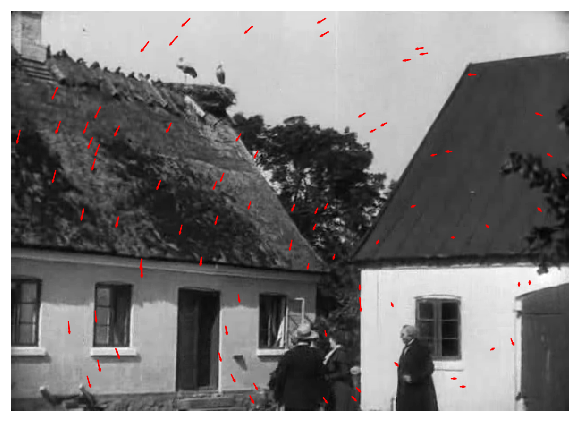

<Figure size 432x288 with 0 Axes>

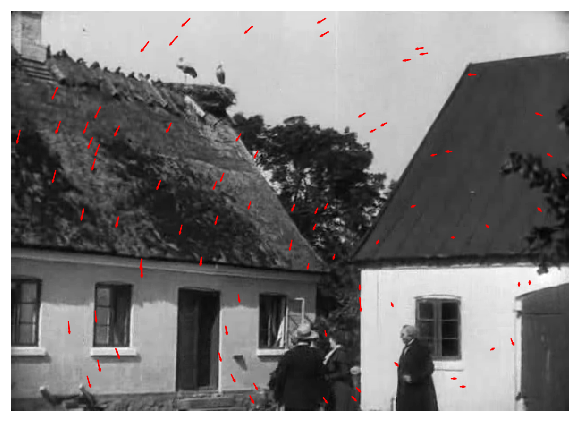

In [13]:
display_motion(img_1,img_2,key_pts,motion)
display_motion(img_1,img_2,key_pts,motion,file_name_1+'_motion_out.png')

__Question__ In what regions do you think the estimation might fail ? Does this visualisation confirm your hypothesis concerning the type of motion ?

<div class="alert alert-info">
<span class="label label-primary" style="font-size:15px;">ANSWER</span> <br>

- The estimation might fail whenever we go far from the rotation center. In this case, the similarity between two patchess would become more important and the value of SSD would increase.

- We can notice that lot of arrows in the visualisation are rotating around the center of rotation and this confirms our hypothesis concerning the type of motion.